[WARN] GPU 실패, CPU 폴백: [06:52:41] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.
VALID(2024 Q4) -> MAE:2101.4  RMSE:2877.4  R^2:0.700  SMAPE:6.39%
TEST  (2025~09-12) 원값 -> MAE:4040.7  RMSE:6024.8  R^2:0.825  SMAPE:8.34%


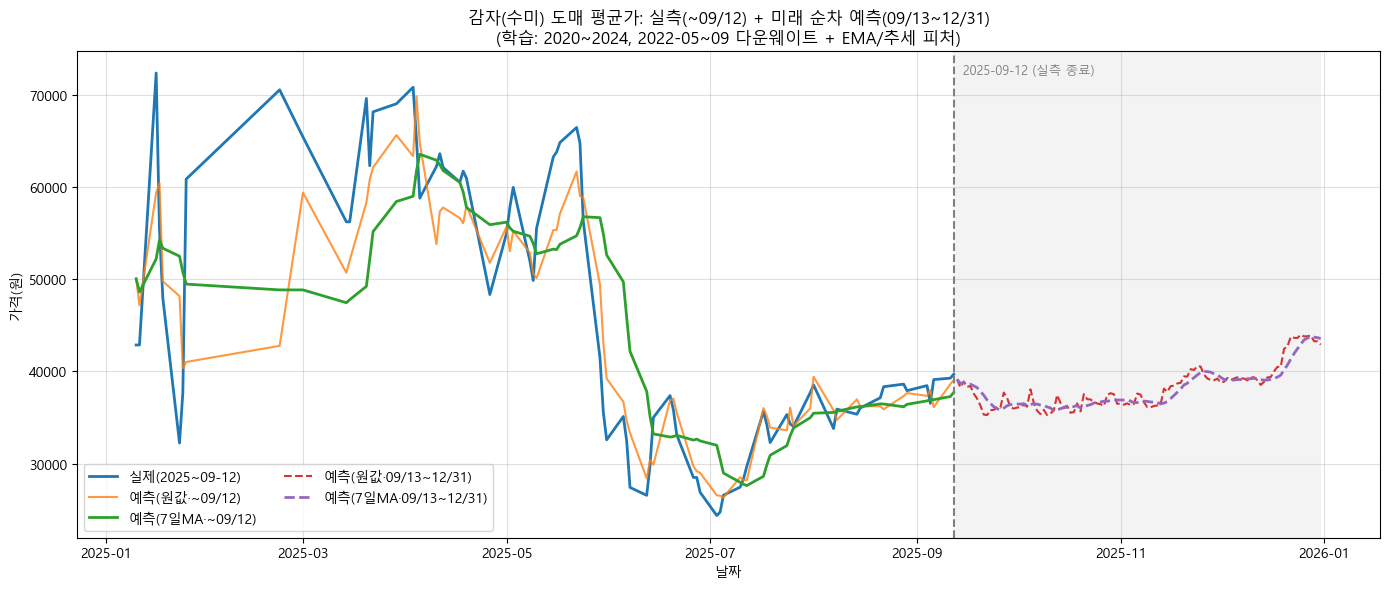

[저장] 평가 CSV : outputs_daily\pred_2025_감자(수미)_평균가_upto_20250912.csv
[저장] 예측 CSV : outputs_daily\pred_2025_감자(수미)_평균가_forecast_20250913_20251231.csv
[저장] 통합 플롯: outputs_daily\plot_2025_감자(수미)_평균가_actual_to_0912_and_forecast_to_1231.png
BACKTEST (2021~23 → 2024) -> MAE:2992.3  RMSE:4154.5  R^2:0.946  SMAPE:7.02%


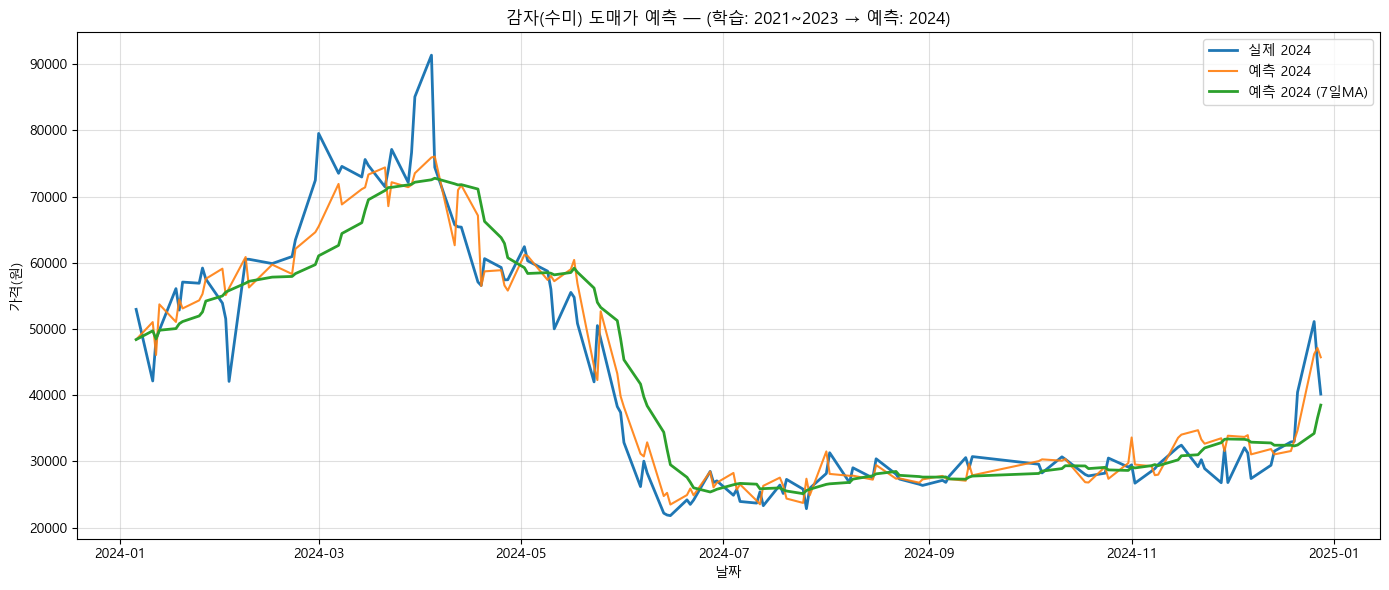

[저장] 2024 예측 플롯: outputs_daily\plot_2024_감자(수미)_평균가_from_21_23.png
[저장] 2024 예측 CSV : outputs_daily\pred_2024_감자(수미)_평균가_from_21_23.csv


In [1]:
# -*- coding: utf-8 -*-
"""
일별 도매가격 예측 파이프라인 (고구마)
- 입력: 고구마도매_csv/*.csv  (컬럼: 일자, 시장, 단위, 품목, 등급, 평균가)
- 사용: 일자와 평균가만 추출하여 병합
- 피처: 달력/주기/추세/다중 랙/EMA/롤링/차분/수익률 (+옵션 YoY)
- 학습: 2020~2024  (★ 2022-05~09 다운웨이트)
- 검증: 2024 마지막 90일 (EarlyStopping)
- 테스트: 2025-01-01 ~ 2025-09-12
- 미래예측: 2025-09-13 ~ 2025-12-31 (순차 예측, 강제)
- 추가 실험: 2021~2023 학습 → 2024 전체 예측 그래프
- 출력: outputs_daily/ 아래 CSV/PNG 저장
"""

import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# =======================
# 설정
# =======================
DATA_DIR   = Path("감자(수미)_csv")     # ← 이 폴더의 CSV만 사용 (일자/평균가)
TARGET_COL = "평균가"
OUT_DIR    = Path("outputs_daily")
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_YOY        = False
EVAL_END_2025  = pd.Timestamp("2025-09-12")
FORECAST_START = pd.Timestamp("2025-09-13")
FORECAST_END   = pd.Timestamp("2025-12-31")

FILL_RECENT_DAYS = 180   # 미래 예측용 결측 보정(중앙값) 계산 구간
PREF = "감자(수미)_평균가"      # 파일명 접두어

np.random.seed(42)

# =======================
# 유틸
# =======================
def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    m = denom != 0
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true)[m] / denom[m])

def report(y_true, y_pred, tag):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"{tag} -> MAE:{mae:.1f}  RMSE:{rmse:.1f}  R^2:{r2:.3f}  SMAPE:{s:.2f}%")

# =======================
# 로딩
# =======================
def read_one_csv(path: Path) -> pd.DataFrame:
    """
    - 기본: 일자/평균가만 사용 (다른 컬럼은 무시)
    - 호환: 구형 포맷(구분/평균)도 자동 매핑
    - 동일 일자 다행 존재 시 일자별 평균값으로 집계
    """
    df = pd.read_csv(path, header=0, dtype=str, encoding="utf-8", engine="python", on_bad_lines="skip")
    df.columns = df.columns.str.strip()

    # 컬럼 호환
    if "일자" in df.columns and TARGET_COL in df.columns:
        date_s = df["일자"].astype(str)
        val_s  = df[TARGET_COL].astype(str)
    elif "구분" in df.columns and "평균" in df.columns:
        date_s = df["구분"].astype(str)
        val_s  = df["평균"].astype(str)
    else:
        # 최소 컬럼 확인 실패 시 스킵
        raise ValueError(f"[{path.name}] '일자/평균가' 또는 '구분/평균' 컬럼이 필요합니다.")

    # 날짜 파싱 (YYYY.MM.DD / YYYY-MM-DD / YYYY/MM/DD 허용)
    date_str = (
        date_s.str.replace(r"[^0-9\.\-\/]", "", regex=True)
               .str.replace("/", ".", regex=False)
               .str.replace("-", ".", regex=False)
    )
    dt = pd.to_datetime(date_str, format="%Y.%m.%d", errors="coerce")

    # 숫자 파싱
    val = pd.to_numeric(val_s.str.replace(",", "", regex=False).str.replace("원", "", regex=False).str.strip(),
                        errors="coerce")

    out = pd.DataFrame({"date": dt, TARGET_COL: val}).dropna()
    # 같은 일자 여러 행 → 일자 평균
    out = out.groupby("date", as_index=False)[TARGET_COL].mean()
    return out

# =======================
# 피처 (행 유지; 결측은 후처리)
# =======================
def build_features(df: pd.DataFrame, target: str) -> pd.DataFrame:
    s = df.sort_values("date").reset_index(drop=True)
    s["y"] = s[target].astype(float)

    # 달력/계절성
    s["year"]  = s["date"].dt.year
    s["month"] = s["date"].dt.month
    s["day"]   = s["date"].dt.day
    s["dow"]   = s["date"].dt.dayofweek
    s["doy"]   = s["date"].dt.dayofyear
    s["week"]  = s["date"].dt.isocalendar().week.astype(int)
    s["quarter"] = s["date"].dt.quarter
    s["is_harvest"] = s["month"].between(9, 11).astype(int)  # 기본 가정 유지

    # 연/월 주기
    s["sin_year"]  = np.sin(2*np.pi*s["doy"]/365.25)
    s["cos_year"]  = np.cos(2*np.pi*s["doy"]/365.25)
    s["sin_month"] = np.sin(2*np.pi*s["day"]/31.0)
    s["cos_month"] = np.cos(2*np.pi*s["day"]/31.0)

    # 추세(장기/단기)
    base = s["date"].min()
    s["trend"]   = (s["date"] - base).dt.days.astype(float)
    s["trend2"]  = s["trend"]**2 / 1e6  # 스케일 안정화

    # 랙
    for L in [1,2,3,7,14,21,28,56,84]:
        s[f"lag_{L}"] = s["y"].shift(L)

    # EMA(지수이동평균)
    s["ema_7"]  = s["y"].shift(1).ewm(span=7,  adjust=False).mean()
    s["ema_28"] = s["y"].shift(1).ewm(span=28, adjust=False).mean()

    # (옵션) YoY
    if USE_YOY:
        for L in [364, 365, 366]:
            s[f"lag_{L}"] = s["y"].shift(L)
        s["yoy_diff"]  = s["y"].shift(1) - s["y"].shift(366)
        s["yoy_ratio"] = (s["y"].shift(1) / s["y"].shift(366)) - 1

    # 롤링(누수 방지: shift(1) 후 rolling) — 최초 예측일 피처 생성을 위해 min_periods=1
    for W in [7,14,28,56]:
        s[f"rmean_{W}"] = s["y"].shift(1).rolling(W, min_periods=1).mean()
        s[f"rstd_{W}"]  = s["y"].shift(1).rolling(W, min_periods=1).std()

    # 변화율/차분 (전일 기준)
    s["diff_1"] = s["y"].shift(1) - s["y"].shift(2)
    s["diff_7"] = s["y"].shift(1) - s["y"].shift(8)
    s["ret_1"]  = s["y"].shift(1) / s["y"].shift(2) - 1
    s["ret_7"]  = s["y"].shift(1) / s["y"].shift(8) - 1

    # 피처 테이블에서 원 타깃 컬럼 제거
    if target in s.columns:
        s = s.drop(columns=[target])

    return s  # dropna 하지 않음

# =======================
# 순차 예측
# =======================
def recursive_forecast_force(model, base_raw: pd.DataFrame,
                             start_date: pd.Timestamp, end_date: pd.Timestamp,
                             feature_cols, fill_values: pd.Series) -> pd.DataFrame:
    """
    base_raw: ['date', TARGET_COL] (미래는 NaN)
    결측 피처는 훈련셋(최근 180일) 중앙값으로 보정하여 반드시 예측.
    """
    work = base_raw.copy().sort_values("date").reset_index(drop=True)
    preds = []
    for d in pd.date_range(start_date, end_date, freq="D"):
        feat_now = build_features(work.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)
        row = feat_now.loc[feat_now["date"] == d, feature_cols]
        if row.empty:
            row = pd.DataFrame([fill_values])    # 안전망
        else:
            row = row.fillna(fill_values)

        y_pred = float(model.predict(row)[0])
        preds.append({"date": d, "pred": y_pred})

        # 예측값 누적(다음 날 랙/EMA/롤링 갱신)
        if (work["date"] == d).any():
            work.loc[work["date"] == d, TARGET_COL] = y_pred
        else:
            work = pd.concat([work, pd.DataFrame({"date":[d], TARGET_COL:[y_pred]})], ignore_index=True)
    return pd.DataFrame(preds)

# =======================
# (추가 실험) 2021~2023 → 2024 예측
# =======================
def backtest_21_23_to_24(feat: pd.DataFrame, feature_cols):
    tr = feat[(feat["date"].dt.year >= 2021) & (feat["date"].dt.year <= 2023) & (feat["y"].notna())].copy()
    te = feat[(feat["date"].dt.year == 2024) & (feat["y"].notna())].copy()
    tr = tr.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    te = te.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)

    X_tr, y_tr = tr[feature_cols], tr["y"]
    X_te, y_te = te[feature_cols], te["y"]

    params = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    m = xgb.XGBRegressor(**params)
    m.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)

    pred = m.predict(X_te)
    report(y_te, pred, "BACKTEST (2021~23 → 2024)")

    # 그래프 저장
    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(14,6))
    plt.plot(te["date"], y_te, label="실제 2024", linewidth=2)
    plt.plot(te["date"], pred,  label="예측 2024", alpha=0.9)
    plt.plot(te["date"], pd.Series(pred).rolling(7, min_periods=1).mean(), label="예측 2024 (7일MA)", linewidth=2)
    plt.title("감자(수미) 도매가 예측 — (학습: 2021~2023 → 예측: 2024)")
    plt.xlabel("날짜"); plt.ylabel("가격(원)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout()
    out_png = OUT_DIR / f"plot_2024_{PREF}_from_21_23.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print(f"[저장] 2024 예측 플롯: {out_png}")

    # CSV 저장
    out_csv = OUT_DIR / f"pred_2024_{PREF}_from_21_23.csv"
    pd.DataFrame({"date": te["date"].values, "actual": y_te.values, "pred": pred}).to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[저장] 2024 예측 CSV : {out_csv}")

# =======================
# 메인 파이프라인
# =======================
def main():
    # 병합
    paths = sorted(glob(str(DATA_DIR/"*.csv")))
    if not paths:
        raise FileNotFoundError(f"{DATA_DIR.resolve()} 에 CSV가 없습니다.")
    frames = [read_one_csv(Path(p)) for p in paths]
    raw = (pd.concat(frames, ignore_index=True)
           .drop_duplicates(subset=["date"])
           .sort_values("date"))
    # 학습/평가 범위 제한 (안전)
    raw = raw[(raw["date"].dt.year>=2020) & (raw["date"].dt.year<=2025)].copy()

    # 날짜 뼈대(연말까지)
    full_dates = pd.date_range(raw["date"].min(), FORECAST_END, freq="D")
    raw = (raw.set_index("date").reindex(full_dates).rename_axis("date").reset_index())

    # 피처
    feat = build_features(raw.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)

    # 피처 목록(이중 가드)
    feature_cols = [c for c in feat.columns if c not in ["date","y", TARGET_COL]]
    assert TARGET_COL not in feature_cols and "y" not in feature_cols

    # 스플릿
    train_all = feat[(feat["date"].dt.year<=2024) & (feat["y"].notna())].copy()
    cut = train_all["date"].max() - pd.Timedelta(days=89)
    train = train_all[train_all["date"] < cut].copy()
    valid = train_all[train_all["date"] >= cut].copy()

    # 학습/검증: 결측 제거
    train = train.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    valid = valid.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    X_tr, y_tr = train[feature_cols], train["y"]
    X_va, y_va = valid[feature_cols], valid["y"]

    # 결측 보정용 중앙값(최근 180일 기준)
    recent_cut = X_tr["trend"].max() - FILL_RECENT_DAYS if "trend" in X_tr.columns else None
    if recent_cut is not None:
        X_recent = X_tr[X_tr["trend"] >= recent_cut]
        fill_values = X_recent.median(numeric_only=True).reindex(feature_cols)
    else:
        fill_values = X_tr.median(numeric_only=True).reindex(feature_cols)

    # 가중치
    w_tr = np.ones(len(train), dtype=float)
    tr_dates = train["date"].to_numpy()
    mask_2205_09 = (tr_dates >= np.datetime64("2022-05-01")) & (tr_dates <= np.datetime64("2022-09-30"))
    w_tr[mask_2205_09] = 0.3
    w_va = np.ones(len(valid), dtype=float)

    # 모델
    params_gpu = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="gpu_hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    params_cpu = {**{k:v for k,v in params_gpu.items() if k!="tree_method"}, "tree_method":"hist"}

    def fit_model(params):
        m = xgb.XGBRegressor(**params)
        m.fit(X_tr, y_tr, sample_weight=w_tr,
              eval_set=[(X_va, y_va)], sample_weight_eval_set=[w_va], verbose=False)
        return m

    try:
        model = fit_model(params_gpu)
    except Exception as e:
        print("[WARN] GPU 실패, CPU 폴백:", e)
        model = fit_model(params_cpu)

    # 평가(~09/12)
    test_2025 = feat[feat["date"].dt.year==2025].copy()
    mask_eval = (test_2025["date"] <= EVAL_END_2025) & (test_2025["y"].notna())
    test_eval = test_2025.loc[mask_eval].dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    y_hat_eval = model.predict(test_eval[feature_cols]) if not test_eval.empty else np.array([])
    report(y_va, model.predict(X_va), "VALID(2024 Q4)")
    if not test_eval.empty:
        report(test_eval["y"], y_hat_eval, "TEST  (2025~09-12) 원값")

    # 미래 예측(09/13~12/31): 순차/강제 예측
    base_for_forecast = raw[["date", TARGET_COL]].copy()  # 미래는 NaN
    future_df = recursive_forecast_force(
        model=model,
        base_raw=base_for_forecast,
        start_date=FORECAST_START,
        end_date=FORECAST_END,
        feature_cols=feature_cols,
        fill_values=fill_values,
    )
    future_df["pred_ma7"] = future_df["pred"].rolling(7, min_periods=1).mean()

    # =======================
    # 결과 저장/시각화 (원값 + MA7)
    # =======================
    # 평가 CSV
    eval_df = test_eval[["date","y"]].rename(columns={"y":"actual"}).copy()
    if len(y_hat_eval)>0:
        eval_df["pred"] = y_hat_eval
        eval_df["pred_ma7"] = pd.Series(eval_df["pred"]).rolling(7, min_periods=1).mean()
    else:
        eval_df["pred"] = np.nan
        eval_df["pred_ma7"] = np.nan
    csv_eval = OUT_DIR / f"pred_2025_{PREF}_upto_{EVAL_END_2025.strftime('%Y%m%d')}.csv"
    eval_df.to_csv(csv_eval, index=False, encoding="utf-8-sig")

    # 미래 CSV
    csv_future = OUT_DIR / f"pred_2025_{PREF}_forecast_{FORECAST_START.strftime('%Y%m%d')}_{FORECAST_END.strftime('%Y%m%d')}.csv"
    future_df.to_csv(csv_future, index=False, encoding="utf-8-sig")

    # 플롯
    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(14,6))

    # 실측(~09/12) + 예측(~09/12)
    if not eval_df.empty:
        plt.plot(eval_df["date"], eval_df["actual"], label="실제(2025~09-12)", linewidth=2)
        plt.plot(eval_df["date"], eval_df["pred"],     label="예측(원값·~09/12)", alpha=0.8)
        plt.plot(eval_df["date"], eval_df["pred_ma7"], label="예측(7일MA·~09/12)", linewidth=2)

    # 미래(09/13~12/31) — 점선
    plt.plot(future_df["date"], future_df["pred"],     linestyle="--", label="예측(원값·09/13~12/31)", alpha=0.95)
    plt.plot(future_df["date"], future_df["pred_ma7"], linestyle="--", linewidth=2, label="예측(7일MA·09/13~12/31)")

    ymin, ymax = plt.gca().get_ylim()
    plt.axvspan(EVAL_END_2025, FORECAST_END, color="lightgray", alpha=0.25, lw=0)
    plt.axvline(EVAL_END_2025, color="gray", linestyle="--", linewidth=1.5)
    plt.text(EVAL_END_2025, ymax*0.98, "  2025-09-12 (실측 종료)", va="top", ha="left", fontsize=9, color="gray")

    plt.title("감자(수미) 도매 평균가: 실측(~09/12) + 미래 순차 예측(09/13~12/31)\n(학습: 2020~2024, 2022-05~09 다운웨이트 + EMA/추세 피처)")
    plt.xlabel("날짜"); plt.ylabel("가격(원)")
    plt.grid(True, alpha=0.4); plt.legend(ncol=2); plt.tight_layout()

    plot_path = OUT_DIR / f"plot_2025_{PREF}_actual_to_0912_and_forecast_to_1231.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print(f"[저장] 평가 CSV : {csv_eval}")
    print(f"[저장] 예측 CSV : {csv_future}")
    print(f"[저장] 통합 플롯: {plot_path}")

    # ===== 추가 실험: 2021~2023 → 2024 예측 =====
    backtest_21_23_to_24(feat, feature_cols)

# ========= 실행 =========
if __name__ == "__main__":
    main()


[WARN] GPU 실패, CPU 폴백: [10:32:48] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.
VALID(2024 Q4) -> MAE:2101.4  RMSE:2877.4  R^2:0.700  SMAPE:6.39%
TEST  (2025~09-12) 원값 -> MAE:4040.7  RMSE:6024.8  R^2:0.825  SMAPE:8.34%


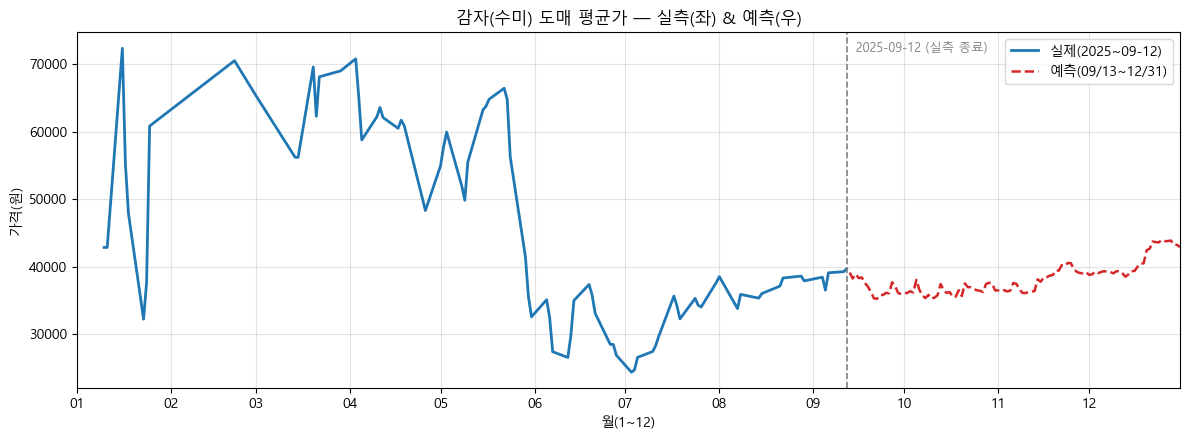

[저장] 통합 플롯: outputs_daily\plot_2025_감자(수미)_평균가_clean_two_segments.png
BACKTEST (2021~23 → 2024) -> MAE:2992.3  RMSE:4154.5  R^2:0.946  SMAPE:7.02%


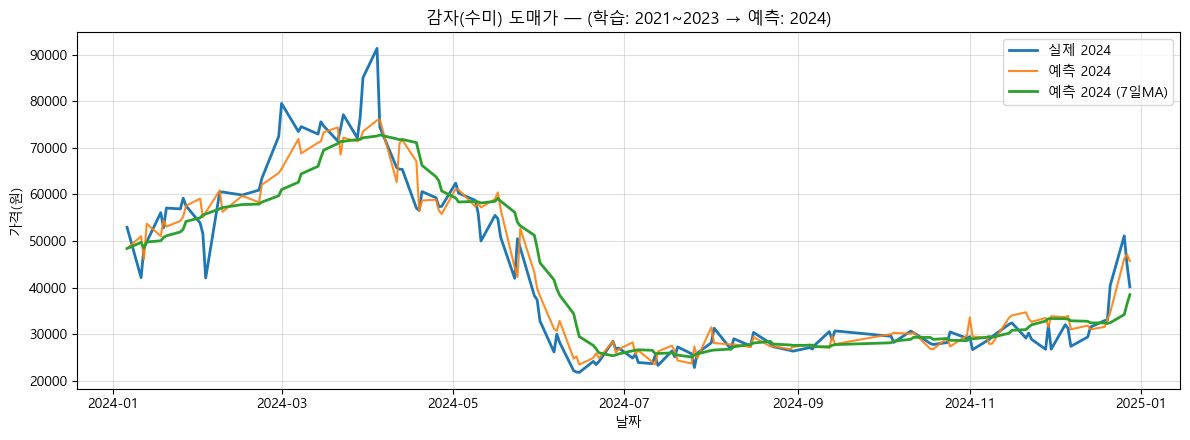

[저장] 2024 예측 플롯: outputs_daily\plot_2024_감자(수미)_평균가_from_21_23.png
[저장] 2024 예측 CSV : outputs_daily\pred_2024_감자(수미)_평균가_from_21_23.csv


In [6]:
# -*- coding: utf-8 -*-
"""
일별 도매가격 예측 파이프라인 (감자(수미))
- 입력: 감자(수미)_csv/*.csv
- 학습: 2020~2024, 검증: 2024 마지막 90일, 테스트: 2025-01-01~09-12
- 미래예측: 2025-09-13~12-31 (순차 예측)
- 플롯: 09/12 이전 파란 실측선만, 09/13 이후 빨간 점선만 / X축 1~12월 표시 / 그림 크기 축소
"""

import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # ← 월별 눈금 표시용

# =======================
# 설정
# =======================
DATA_DIR   = Path("감자(수미)_csv")     # ← 폴더명
TARGET_COL = "평균가"
OUT_DIR    = Path("outputs_daily")
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_YOY        = False
EVAL_END_2025  = pd.Timestamp("2025-09-12")
FORECAST_START = pd.Timestamp("2025-09-13")
FORECAST_END   = pd.Timestamp("2025-12-31")

FILL_RECENT_DAYS = 180
PREF = "감자(수미)_평균가"

np.random.seed(42)

# =======================
# 유틸
# =======================
def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    m = denom != 0
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true)[m] / denom[m])

def report(y_true, y_pred, tag):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"{tag} -> MAE:{mae:.1f}  RMSE:{rmse:.1f}  R^2:{r2:.3f}  SMAPE:{s:.2f}%")

# =======================
# 로딩
# =======================
def read_one_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, header=0, dtype=str, encoding="utf-8", engine="python", on_bad_lines="skip")
    df.columns = df.columns.str.strip()

    if "일자" in df.columns and TARGET_COL in df.columns:
        date_s = df["일자"].astype(str)
        val_s  = df[TARGET_COL].astype(str)
    elif "구분" in df.columns and "평균" in df.columns:
        date_s = df["구분"].astype(str)
        val_s  = df["평균"].astype(str)
    else:
        raise ValueError(f"[{path.name}] '일자/평균가' 또는 '구분/평균' 컬럼이 필요합니다.")

    date_str = (
        date_s.str.replace(r"[^0-9\.\-\/]", "", regex=True)
              .str.replace("/", ".", regex=False)
              .str.replace("-", ".", regex=False)
    )
    dt = pd.to_datetime(date_str, format="%Y.%m.%d", errors="coerce")

    val = pd.to_numeric(val_s.str.replace(",", "", regex=False).str.replace("원", "", regex=False).str.strip(),
                        errors="coerce")

    out = pd.DataFrame({"date": dt, TARGET_COL: val}).dropna()
    out = out.groupby("date", as_index=False)[TARGET_COL].mean()
    return out

# =======================
# 피처
# =======================
def build_features(df: pd.DataFrame, target: str) -> pd.DataFrame:
    s = df.sort_values("date").reset_index(drop=True)
    s["y"] = s[target].astype(float)

    s["year"]  = s["date"].dt.year
    s["month"] = s["date"].dt.month
    s["day"]   = s["date"].dt.day
    s["dow"]   = s["date"].dt.dayofweek
    s["doy"]   = s["date"].dt.dayofyear
    s["week"]  = s["date"].dt.isocalendar().week.astype(int)
    s["quarter"] = s["date"].dt.quarter
    s["is_harvest"] = s["month"].between(9, 11).astype(int)

    s["sin_year"]  = np.sin(2*np.pi*s["doy"]/365.25)
    s["cos_year"]  = np.cos(2*np.pi*s["doy"]/365.25)
    s["sin_month"] = np.sin(2*np.pi*s["day"]/31.0)
    s["cos_month"] = np.cos(2*np.pi*s["day"]/31.0)

    base = s["date"].min()
    s["trend"]   = (s["date"] - base).dt.days.astype(float)
    s["trend2"]  = s["trend"]**2 / 1e6

    for L in [1,2,3,7,14,21,28,56,84]:
        s[f"lag_{L}"] = s["y"].shift(L)

    s["ema_7"]  = s["y"].shift(1).ewm(span=7,  adjust=False).mean()
    s["ema_28"] = s["y"].shift(1).ewm(span=28, adjust=False).mean()

    if USE_YOY:
        for L in [364, 365, 366]:
            s[f"lag_{L}"] = s["y"].shift(L)
        s["yoy_diff"]  = s["y"].shift(1) - s["y"].shift(366)
        s["yoy_ratio"] = (s["y"].shift(1) / s["y"].shift(366)) - 1

    for W in [7,14,28,56]:
        s[f"rmean_{W}"] = s["y"].shift(1).rolling(W, min_periods=1).mean()
        s[f"rstd_{W}"]  = s["y"].shift(1).rolling(W, min_periods=1).std()

    s["diff_1"] = s["y"].shift(1) - s["y"].shift(2)
    s["diff_7"] = s["y"].shift(1) - s["y"].shift(8)
    s["ret_1"]  = s["y"].shift(1) / s["y"].shift(2) - 1
    s["ret_7"]  = s["y"].shift(1) / s["y"].shift(8) - 1

    if target in s.columns:
        s = s.drop(columns=[target])

    return s  # dropna 하지 않음

# =======================
# 순차 예측 (강제)
# =======================
def recursive_forecast_force(model, base_raw: pd.DataFrame,
                             start_date: pd.Timestamp, end_date: pd.Timestamp,
                             feature_cols, fill_values: pd.Series) -> pd.DataFrame:
    work = base_raw.copy().sort_values("date").reset_index(drop=True)
    preds = []
    for d in pd.date_range(start_date, end_date, freq="D"):
        feat_now = build_features(work.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)
        row = feat_now.loc[feat_now["date"] == d, feature_cols]
        if row.empty:
            row = pd.DataFrame([fill_values])
        else:
            row = row.fillna(fill_values)

        y_pred = float(model.predict(row)[0])
        preds.append({"date": d, "pred": y_pred})

        if (work["date"] == d).any():
            work.loc[work["date"] == d, TARGET_COL] = y_pred
        else:
            work = pd.concat([work, pd.DataFrame({"date":[d], TARGET_COL:[y_pred]})], ignore_index=True)
    return pd.DataFrame(preds)

# =======================
# (추가) 2021~2023 → 2024
# =======================
def backtest_21_23_to_24(feat: pd.DataFrame, feature_cols):
    tr = feat[(feat["date"].dt.year >= 2021) & (feat["date"].dt.year <= 2023) & (feat["y"].notna())].copy()
    te = feat[(feat["date"].dt.year == 2024) & (feat["y"].notna())].copy()
    tr = tr.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    te = te.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)

    X_tr, y_tr = tr[feature_cols], tr["y"]
    X_te, y_te = te[feature_cols], te["y"]

    params = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    m = xgb.XGBRegressor(**params)
    m.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)

    pred = m.predict(X_te)
    report(y_te, pred, "BACKTEST (2021~23 → 2024)")

    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(12,4.5))
    plt.plot(te["date"], y_te, label="실제 2024", linewidth=2)
    plt.plot(te["date"], pred,  label="예측 2024", alpha=0.9)
    plt.plot(te["date"], pd.Series(pred).rolling(7, min_periods=1).mean(), label="예측 2024 (7일MA)", linewidth=2)
    plt.title("감자(수미) 도매가 — (학습: 2021~2023 → 예측: 2024)")
    plt.xlabel("날짜"); plt.ylabel("가격(원)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout()
    out_png = OUT_DIR / f"plot_2024_{PREF}_from_21_23.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print(f"[저장] 2024 예측 플롯: {out_png}")

    out_csv = OUT_DIR / f"pred_2024_{PREF}_from_21_23.csv"
    pd.DataFrame({"date": te["date"].values, "actual": y_te.values, "pred": pred}).to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[저장] 2024 예측 CSV : {out_csv}")

# =======================
# 메인 파이프라인
# =======================
def main():
    # 병합
    paths = sorted(glob(str(DATA_DIR/"*.csv")))
    if not paths:
        raise FileNotFoundError(f"{DATA_DIR.resolve()} 에 CSV가 없습니다.")
    frames = [read_one_csv(Path(p)) for p in paths]
    raw = (pd.concat(frames, ignore_index=True)
           .drop_duplicates(subset=["date"])
           .sort_values("date"))
    raw = raw[(raw["date"].dt.year>=2020) & (raw["date"].dt.year<=2025)].copy()

    # 날짜 뼈대(연말까지)
    full_dates = pd.date_range(raw["date"].min(), FORECAST_END, freq="D")
    raw = (raw.set_index("date").reindex(full_dates).rename_axis("date").reset_index())

    # 피처
    feat = build_features(raw.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)

    # 피처 목록
    feature_cols = [c for c in feat.columns if c not in ["date","y", TARGET_COL]]
    assert TARGET_COL not in feature_cols and "y" not in feature_cols

    # 스플릿
    train_all = feat[(feat["date"].dt.year<=2024) & (feat["y"].notna())].copy()
    cut = train_all["date"].max() - pd.Timedelta(days=89)
    train = train_all[train_all["date"] < cut].copy()
    valid = train_all[train_all["date"] >= cut].copy()

    # 학습/검증: 결측 제거
    train = train.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    valid = valid.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    X_tr, y_tr = train[feature_cols], train["y"]
    X_va, y_va = valid[feature_cols], valid["y"]

    # 결측 보정용 중앙값
    recent_cut = X_tr["trend"].max() - FILL_RECENT_DAYS if "trend" in X_tr.columns else None
    if recent_cut is not None:
        X_recent = X_tr[X_tr["trend"] >= recent_cut]
        fill_values = X_recent.median(numeric_only=True).reindex(feature_cols)
    else:
        fill_values = X_tr.median(numeric_only=True).reindex(feature_cols)

    # 가중치
    w_tr = np.ones(len(train), dtype=float)
    tr_dates = train["date"].to_numpy()
    mask_2205_09 = (tr_dates >= np.datetime64("2022-05-01")) & (tr_dates <= np.datetime64("2022-09-30"))
    w_tr[mask_2205_09] = 0.3
    w_va = np.ones(len(valid), dtype=float)

    # 모델
    params_gpu = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="gpu_hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    params_cpu = {**{k:v for k,v in params_gpu.items() if k!="tree_method"}, "tree_method":"hist"}

    def fit_model(params):
        m = xgb.XGBRegressor(**params)
        m.fit(X_tr, y_tr, sample_weight=w_tr,
              eval_set=[(X_va, y_va)], sample_weight_eval_set=[w_va], verbose=False)
        return m

    try:
        model = fit_model(params_gpu)
    except Exception as e:
        print("[WARN] GPU 실패, CPU 폴백:", e)
        model = fit_model(params_cpu)

    # 평가(~09/12)
    test_2025 = feat[feat["date"].dt.year==2025].copy()
    mask_eval = (test_2025["date"] <= EVAL_END_2025) & (test_2025["y"].notna())
    test_eval = test_2025.loc[mask_eval].dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    y_hat_eval = model.predict(test_eval[feature_cols]) if not test_eval.empty else np.array([])
    report(y_va, model.predict(X_va), "VALID(2024 Q4)")
    if not test_eval.empty:
        report(test_eval["y"], y_hat_eval, "TEST  (2025~09-12) 원값")

    # 미래 예측(09/13~12/31)
    base_for_forecast = raw[["date", TARGET_COL]].copy()
    future_df = recursive_forecast_force(
        model=model,
        base_raw=base_for_forecast,
        start_date=FORECAST_START,
        end_date=FORECAST_END,
        feature_cols=feature_cols,
        fill_values=fill_values,
    )

    # =======================
    # 플롯 (요청대로 단순화/크기 축소/월 표시)
    # =======================
    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(12,4.5))  # ← 크기 줄임

    # 왼쪽: 실측(파란색)만
    if not test_eval.empty:
        plt.plot(test_eval["date"], test_eval["y"], color="tab:blue",
                 label="실제(2025~09-12)", linewidth=2)

    # 기준선
    plt.axvline(EVAL_END_2025, color="gray", linestyle="--", linewidth=1.2)
    plt.text(EVAL_END_2025, plt.gca().get_ylim()[1]*0.98,
             "  2025-09-12 (실측 종료)", va="top", ha="left", fontsize=9, color="gray")

    # 오른쪽: 예측(빨간 점선)만
    plt.plot(future_df["date"], future_df["pred"], color="tab:red",
             linestyle="--", linewidth=1.8, label="예측(09/13~12/31)")

    # X축: 2025년 1~12월 모두 표시
    ax = plt.gca()
    ax.set_xlim(pd.Timestamp("2025-01-01"), FORECAST_END)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))  # 01~12
    plt.xlabel("월(1~12)"); plt.ylabel("가격(원)")

    plt.title("감자(수미) 도매 평균가 — 실측(좌) & 예측(우)")
    plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()

    plot_path = OUT_DIR / f"plot_2025_{PREF}_clean_two_segments.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print(f"[저장] 통합 플롯: {plot_path}")

    # ===== 선택: 백테스트 =====
    backtest_21_23_to_24(feat, feature_cols)

# ========= 실행 =========
if __name__ == "__main__":
    main()


[WARN] GPU 실패, CPU 폴백: [10:34:33] C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\common\common.h:174: XGBoost version not compiled with GPU support.
VALID(2024 Q4) -> MAE:2101.4  RMSE:2877.4  R^2:0.700  SMAPE:6.39%
TEST  (2025~09-12) 원값 -> MAE:4040.7  RMSE:6024.8  R^2:0.825  SMAPE:8.34%

[예측 표] 2025-09-13 ~ 2025-12-31 (date, y)
2025-09-13 39,135
2025-09-14 38,264
2025-09-15 38,900
2025-09-16 38,319
2025-09-17 38,423
2025-09-18 37,596
2025-09-19 37,061
2025-09-20 36,300
2025-09-21 35,324
2025-09-22 35,258
2025-09-23 35,797
2025-09-24 35,825
2025-09-25 36,137
2025-09-26 36,072
2025-09-27 37,702
2025-09-28 37,128
2025-09-29 36,110
2025-09-30 35,967
2025-10-01 36,078
2025-10-02 36,123
2025-10-03 36,386
2025-10-04 36,178
2025-10-05 38,057
2025-10-06 36,590
2025-10-07 35,734
2025-10-08 35,366
2025-10-09 35,830
2025-10-10 35,261
2025-10-11 35,433
2025-10-12 35,773
2025-10-13 37,444
2025-10-14 36,576
2025-10-15 36,121
2025-10-16 36,257
2025-10-17 35,517
2025-10-18 35,584
2025-1

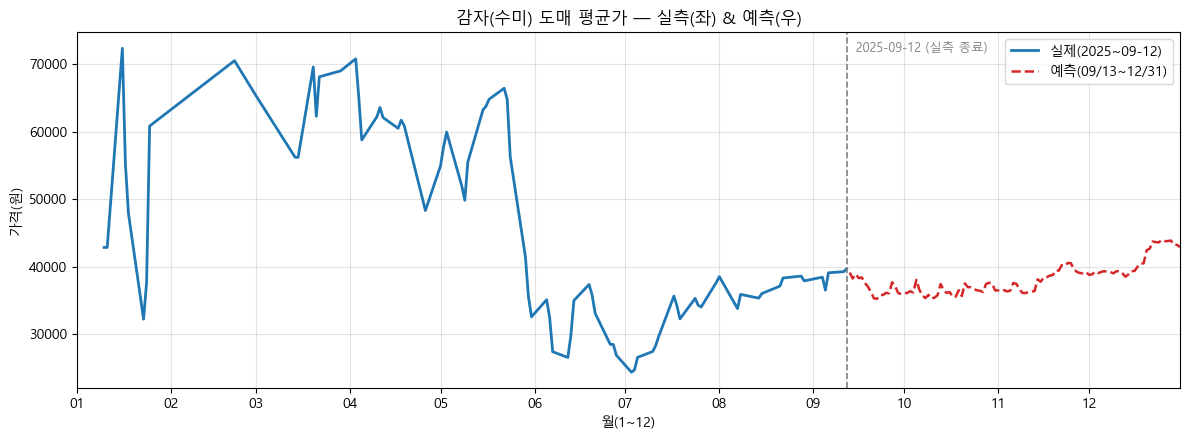

[저장] 통합 플롯: outputs_daily\plot_2025_감자(수미)_평균가_clean_two_segments.png
BACKTEST (2021~23 → 2024) -> MAE:2992.3  RMSE:4154.5  R^2:0.946  SMAPE:7.02%


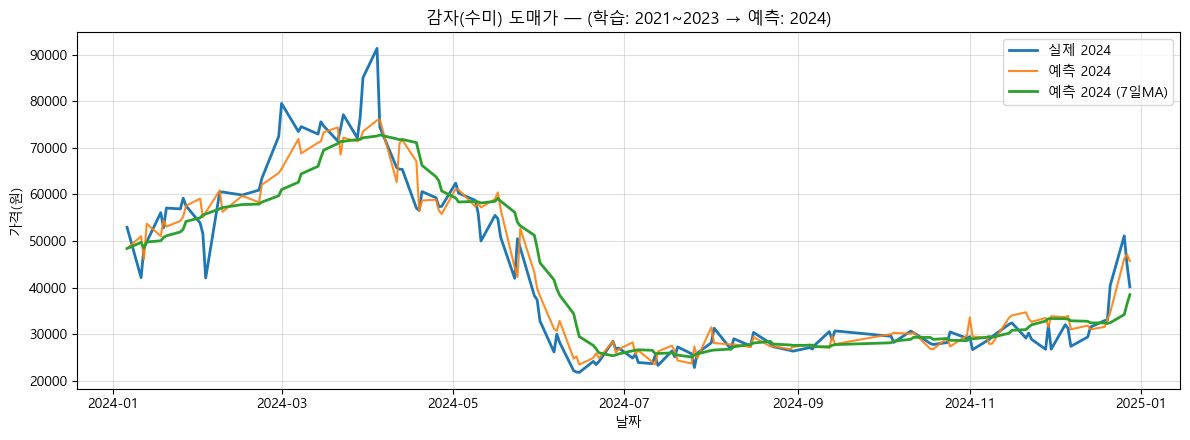

[저장] 2024 예측 플롯: outputs_daily\plot_2024_감자(수미)_평균가_from_21_23.png
[저장] 2024 예측 CSV : outputs_daily\pred_2024_감자(수미)_평균가_from_21_23.csv


In [7]:
# -*- coding: utf-8 -*-
"""
일별 도매가격 예측 파이프라인 (감자(수미))
- 입력: 감자(수미)_csv/*.csv
- 학습: 2020~2024, 검증: 2024 마지막 90일, 테스트: 2025-01-01~09-12
- 미래예측: 2025-09-13~12-31 (순차 예측)
- 플롯: 09/12 이전 파란 실측선만, 09/13 이후 빨간 점선만 / X축 1~12월 표시 / 그림 크기 축소
- 추가: 2025-09-13 ~ 2025-12-31 예측값 (날짜, y) 콘솔 출력 + CSV 저장
"""

import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # ← 월별 눈금 표시용

# =======================
# 설정
# =======================
DATA_DIR   = Path("감자(수미)_csv")     # ← 폴더명
TARGET_COL = "평균가"
OUT_DIR    = Path("outputs_daily")
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_YOY        = False
EVAL_END_2025  = pd.Timestamp("2025-09-12")
FORECAST_START = pd.Timestamp("2025-09-13")
FORECAST_END   = pd.Timestamp("2025-12-31")

FILL_RECENT_DAYS = 180
PREF = "감자(수미)_평균가"

np.random.seed(42)

# =======================
# 유틸
# =======================
def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    m = denom != 0
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true)[m] / denom[m])

def report(y_true, y_pred, tag):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"{tag} -> MAE:{mae:.1f}  RMSE:{rmse:.1f}  R^2:{r2:.3f}  SMAPE:{s:.2f}%")

# =======================
# 로딩
# =======================
def read_one_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, header=0, dtype=str, encoding="utf-8", engine="python", on_bad_lines="skip")
    df.columns = df.columns.str.strip()

    if "일자" in df.columns and TARGET_COL in df.columns:
        date_s = df["일자"].astype(str)
        val_s  = df[TARGET_COL].astype(str)
    elif "구분" in df.columns and "평균" in df.columns:
        date_s = df["구분"].astype(str)
        val_s  = df["평균"].astype(str)
    else:
        raise ValueError(f"[{path.name}] '일자/평균가' 또는 '구분/평균' 컬럼이 필요합니다.")

    date_str = (
        date_s.str.replace(r"[^0-9\.\-\/]", "", regex=True)
              .str.replace("/", ".", regex=False)
              .str.replace("-", ".", regex=False)
    )
    dt = pd.to_datetime(date_str, format="%Y.%m.%d", errors="coerce")

    val = pd.to_numeric(val_s.str.replace(",", "", regex=False).str.replace("원", "", regex=False).str.strip(),
                        errors="coerce")

    out = pd.DataFrame({"date": dt, TARGET_COL: val}).dropna()
    out = out.groupby("date", as_index=False)[TARGET_COL].mean()
    return out

# =======================
# 피처
# =======================
def build_features(df: pd.DataFrame, target: str) -> pd.DataFrame:
    s = df.sort_values("date").reset_index(drop=True)
    s["y"] = s[target].astype(float)

    s["year"]  = s["date"].dt.year
    s["month"] = s["date"].dt.month
    s["day"]   = s["date"].dt.day
    s["dow"]   = s["date"].dt.dayofweek
    s["doy"]   = s["date"].dt.dayofyear
    s["week"]  = s["date"].dt.isocalendar().week.astype(int)
    s["quarter"] = s["date"].dt.quarter
    s["is_harvest"] = s["month"].between(9, 11).astype(int)

    s["sin_year"]  = np.sin(2*np.pi*s["doy"]/365.25)
    s["cos_year"]  = np.cos(2*np.pi*s["doy"]/365.25)
    s["sin_month"] = np.sin(2*np.pi*s["day"]/31.0)
    s["cos_month"] = np.cos(2*np.pi*s["day"]/31.0)

    base = s["date"].min()
    s["trend"]   = (s["date"] - base).dt.days.astype(float)
    s["trend2"]  = s["trend"]**2 / 1e6

    for L in [1,2,3,7,14,21,28,56,84]:
        s[f"lag_{L}"] = s["y"].shift(L)

    s["ema_7"]  = s["y"].shift(1).ewm(span=7,  adjust=False).mean()
    s["ema_28"] = s["y"].shift(1).ewm(span=28, adjust=False).mean()

    if USE_YOY:
        for L in [364, 365, 366]:
            s[f"lag_{L}"] = s["y"].shift(L)
        s["yoy_diff"]  = s["y"].shift(1) - s["y"].shift(366)
        s["yoy_ratio"] = (s["y"].shift(1) / s["y"].shift(366)) - 1

    for W in [7,14,28,56]:
        s[f"rmean_{W}"] = s["y"].shift(1).rolling(W, min_periods=1).mean()
        s[f"rstd_{W}"]  = s["y"].shift(1).rolling(W, min_periods=1).std()

    s["diff_1"] = s["y"].shift(1) - s["y"].shift(2)
    s["diff_7"] = s["y"].shift(1) - s["y"].shift(8)
    s["ret_1"]  = s["y"].shift(1) / s["y"].shift(2) - 1
    s["ret_7"]  = s["y"].shift(1) / s["y"].shift(8) - 1

    if target in s.columns:
        s = s.drop(columns=[target])

    return s  # dropna 하지 않음

# =======================
# 순차 예측 (강제)
# =======================
def recursive_forecast_force(model, base_raw: pd.DataFrame,
                             start_date: pd.Timestamp, end_date: pd.Timestamp,
                             feature_cols, fill_values: pd.Series) -> pd.DataFrame:
    work = base_raw.copy().sort_values("date").reset_index(drop=True)
    preds = []
    for d in pd.date_range(start_date, end_date, freq="D"):
        feat_now = build_features(work.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)
        row = feat_now.loc[feat_now["date"] == d, feature_cols]
        if row.empty:
            row = pd.DataFrame([fill_values])
        else:
            row = row.fillna(fill_values)

        y_pred = float(model.predict(row)[0])
        preds.append({"date": d, "pred": y_pred})

        if (work["date"] == d).any():
            work.loc[work["date"] == d, TARGET_COL] = y_pred
        else:
            work = pd.concat([work, pd.DataFrame({"date":[d], TARGET_COL:[y_pred]})], ignore_index=True)
    return pd.DataFrame(preds)

# =======================
# (추가) 2021~2023 → 2024
# =======================
def backtest_21_23_to_24(feat: pd.DataFrame, feature_cols):
    tr = feat[(feat["date"].dt.year >= 2021) & (feat["date"].dt.year <= 2023) & (feat["y"].notna())].copy()
    te = feat[(feat["date"].dt.year == 2024) & (feat["y"].notna())].copy()
    tr = tr.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    te = te.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)

    X_tr, y_tr = tr[feature_cols], tr["y"]
    X_te, y_te = te[feature_cols], te["y"]

    params = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    m = xgb.XGBRegressor(**params)
    m.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)

    pred = m.predict(X_te)
    report(y_te, pred, "BACKTEST (2021~23 → 2024)")

    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(12,4.5))
    plt.plot(te["date"], y_te, label="실제 2024", linewidth=2)
    plt.plot(te["date"], pred,  label="예측 2024", alpha=0.9)
    plt.plot(te["date"], pd.Series(pred).rolling(7, min_periods=1).mean(), label="예측 2024 (7일MA)", linewidth=2)
    plt.title("감자(수미) 도매가 — (학습: 2021~2023 → 예측: 2024)")
    plt.xlabel("날짜"); plt.ylabel("가격(원)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout()
    out_png = OUT_DIR / f"plot_2024_{PREF}_from_21_23.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print(f"[저장] 2024 예측 플롯: {out_png}")

    out_csv = OUT_DIR / f"pred_2024_{PREF}_from_21_23.csv"
    pd.DataFrame({"date": te["date"].values, "actual": y_te.values, "pred": pred}).to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[저장] 2024 예측 CSV : {out_csv}")

# =======================
# 메인 파이프라인
# =======================
def main():
    # 병합
    paths = sorted(glob(str(DATA_DIR/"*.csv")))
    if not paths:
        raise FileNotFoundError(f"{DATA_DIR.resolve()} 에 CSV가 없습니다.")
    frames = [read_one_csv(Path(p)) for p in paths]
    raw = (pd.concat(frames, ignore_index=True)
           .drop_duplicates(subset=["date"])
           .sort_values("date"))
    raw = raw[(raw["date"].dt.year>=2020) & (raw["date"].dt.year<=2025)].copy()

    # 날짜 뼈대(연말까지)
    full_dates = pd.date_range(raw["date"].min(), FORECAST_END, freq="D")
    raw = (raw.set_index("date").reindex(full_dates).rename_axis("date").reset_index())

    # 피처
    feat = build_features(raw.rename(columns={TARGET_COL:"val"}).rename(columns={"val":TARGET_COL}), TARGET_COL)

    # 피처 목록
    feature_cols = [c for c in feat.columns if c not in ["date","y", TARGET_COL]]
    assert TARGET_COL not in feature_cols and "y" not in feature_cols

    # 스플릿
    train_all = feat[(feat["date"].dt.year<=2024) & (feat["y"].notna())].copy()
    cut = train_all["date"].max() - pd.Timedelta(days=89)
    train = train_all[train_all["date"] < cut].copy()
    valid = train_all[train_all["date"] >= cut].copy()

    # 학습/검증: 결측 제거
    train = train.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    valid = valid.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    X_tr, y_tr = train[feature_cols], train["y"]
    X_va, y_va = valid[feature_cols], valid["y"]

    # 결측 보정용 중앙값
    recent_cut = X_tr["trend"].max() - FILL_RECENT_DAYS if "trend" in X_tr.columns else None
    if recent_cut is not None:
        X_recent = X_tr[X_tr["trend"] >= recent_cut]
        fill_values = X_recent.median(numeric_only=True).reindex(feature_cols)
    else:
        fill_values = X_tr.median(numeric_only=True).reindex(feature_cols)

    # 가중치
    w_tr = np.ones(len(train), dtype=float)
    tr_dates = train["date"].to_numpy()
    mask_2205_09 = (tr_dates >= np.datetime64("2022-05-01")) & (tr_dates <= np.datetime64("2022-09-30"))
    w_tr[mask_2205_09] = 0.3
    w_va = np.ones(len(valid), dtype=float)

    # 모델
    params_gpu = dict(
        n_estimators=5000, learning_rate=0.01, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=2.0, reg_alpha=0.0,
        random_state=42, tree_method="gpu_hist", early_stopping_rounds=200, eval_metric="rmse",
    )
    params_cpu = {**{k:v for k,v in params_gpu.items() if k!="tree_method"}, "tree_method":"hist"}

    def fit_model(params):
        m = xgb.XGBRegressor(**params)
        m.fit(X_tr, y_tr, sample_weight=w_tr,
              eval_set=[(X_va, y_va)], sample_weight_eval_set=[w_va], verbose=False)
        return m

    try:
        model = fit_model(params_gpu)
    except Exception as e:
        print("[WARN] GPU 실패, CPU 폴백:", e)
        model = fit_model(params_cpu)

    # 평가(~09/12)
    test_2025 = feat[feat["date"].dt.year==2025].copy()
    mask_eval = (test_2025["date"] <= EVAL_END_2025) & (test_2025["y"].notna())
    test_eval = test_2025.loc[mask_eval].dropna(subset=feature_cols + ["y"]).reset_index(drop=True)
    y_hat_eval = model.predict(test_eval[feature_cols]) if not test_eval.empty else np.array([])
    report(y_va, model.predict(X_va), "VALID(2024 Q4)")
    if not test_eval.empty:
        report(test_eval["y"], y_hat_eval, "TEST  (2025~09-12) 원값")

    # 미래 예측(09/13~12/31)
    base_for_forecast = raw[["date", TARGET_COL]].copy()
    future_df = recursive_forecast_force(
        model=model,
        base_raw=base_for_forecast,
        start_date=FORECAST_START,
        end_date=FORECAST_END,
        feature_cols=feature_cols,
        fill_values=fill_values,
    )

    # ====== 추가: 2025-09-13 ~ 2025-12-31 예측값 (date, y) 콘솔 출력 + CSV 저장 ======
    mask_future = (future_df["date"] >= FORECAST_START) & (future_df["date"] <= FORECAST_END)
    tbl = future_df.loc[mask_future, ["date", "pred"]].rename(columns={"pred": "y"}).reset_index(drop=True)

    print("\n[예측 표] 2025-09-13 ~ 2025-12-31 (date, y)")
    # 한 줄씩 확실히 모두 출력
    for d, y in tbl.itertuples(index=False):
        print(d.strftime("%Y-%m-%d"), f"{y:,.0f}")

    out_csv = OUT_DIR / f"forecast_2025_{PREF}_0913_1231.csv"
    tbl.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[저장] {out_csv}")
    # ===========================================================================

    # =======================
    # 플롯 (요청대로 단순화/크기 축소/월 표시)
    # =======================
    plt.rcParams["font.family"] = "Malgun Gothic"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(12,4.5))  # ← 크기 줄임

    # 왼쪽: 실측(파란색)만
    if not test_eval.empty:
        plt.plot(test_eval["date"], test_eval["y"], color="tab:blue",
                 label="실제(2025~09-12)", linewidth=2)

    # 기준선
    plt.axvline(EVAL_END_2025, color="gray", linestyle="--", linewidth=1.2)
    plt.text(EVAL_END_2025, plt.gca().get_ylim()[1]*0.98,
             "  2025-09-12 (실측 종료)", va="top", ha="left", fontsize=9, color="gray")

    # 오른쪽: 예측(빨간 점선)만
    plt.plot(future_df["date"], future_df["pred"], color="tab:red",
             linestyle="--", linewidth=1.8, label="예측(09/13~12/31)")

    # X축: 2025년 1~12월 모두 표시
    ax = plt.gca()
    ax.set_xlim(pd.Timestamp("2025-01-01"), FORECAST_END)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))  # 01~12
    plt.xlabel("월(1~12)"); plt.ylabel("가격(원)")

    plt.title("감자(수미) 도매 평균가 — 실측(좌) & 예측(우)")
    plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()

    plot_path = OUT_DIR / f"plot_2025_{PREF}_clean_two_segments.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print(f"[저장] 통합 플롯: {plot_path}")

    # ===== 선택: 백테스트 =====
    backtest_21_23_to_24(feat, feature_cols)

# ========= 실행 =========
if __name__ == "__main__":
    main()
